In [2]:
import pandas
dfp_marseille_12me = pandas.read_csv('dfp_marseille_12me.csv',
                index_col=17,
                parse_dates=['Date'], date_format="%Y-%m-%d" )  

In [3]:
dfp_marseille_12me.head()

,Unnamed: 0,LAMBX,LAMBY,DATE,DECADE,PRENEI_DECAD,PRELIQ_DECAD,PRETOTD_DECAD,T_DECAD,EVAP_DECAD,ETP_DECAD,PE_DECAD,SWI_DECAD,SSWI_DECAD,ECOULEMENT_DECAD,DRAINC_DECAD,RUNC_DECAD,Ville
Date,,,,,,,,,,,,,,,,,,
1958-08-01,381633,852000,1817000,195808,1,0.0,0.2,0.2,23.2,1.8,58.0,-1.6,0.057,-0.64,0.0,0.0,0.0,Marseille-12eme
1958-08-11,381634,852000,1817000,195808,2,0.0,0.2,0.2,22.7,1.5,51.8,-1.3,0.046,-0.60,0.0,0.0,0.0,Marseille-12eme
1958-08-21,381635,852000,1817000,195808,3,0.0,5.6,5.6,21.6,5.2,42.8,0.4,0.053,-0.32,0.0,0.0,0.0,Marseille-12eme
1958-09-01,381636,852000,1817000,195809,1,0.0,1.6,1.6,21.7,2.3,32.3,-0.7,0.044,-0.72,0.0,0.0,0.0,Marseille-12eme
1958-09-11,381637,852000,1817000,195809,2,0.0,30.9,30.9,20.9,11.6,28.4,19.3,0.110,-0.30,0.0,0.3,0.9,Marseille-12eme


In [4]:
# Construction de la série temporelle des données brutes de temperatures
temps_serie = pandas.Series(dfp_marseille_12me.loc[:,'T_DECAD'], 
                  dfp_marseille_12me.index)
temps_serie.head()

Date
1958-08-01    23.2
1958-08-11    22.7
1958-08-21    21.6
1958-09-01    21.7
1958-09-11    20.9
Name: T_DECAD, dtype: float64

In [5]:
''' Information sur l'interval de date des données '''
print(temps_serie.index.min(), temps_serie.index.max())

1958-08-01 00:00:00 2025-09-11 00:00:00


In [6]:
# Serie des temperatures estivales uniquement
temps_estivales_serie = temps_serie.loc[temps_serie.index.month.isin([7,8])]

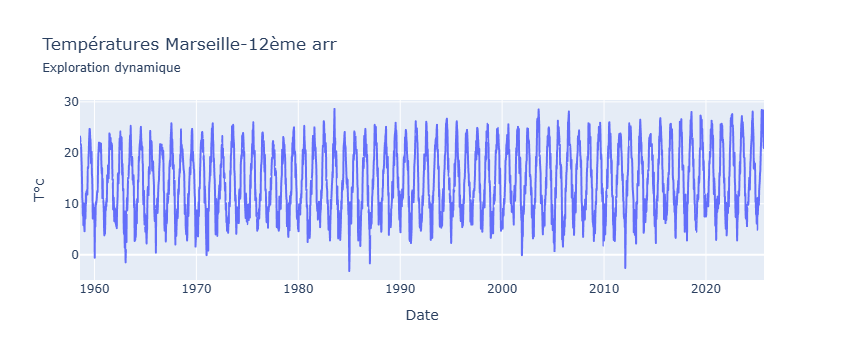

In [7]:
''' Visualiation des temperatures au cours des années '''
import plotly.express as px
fig = px.line( x=temps_serie.index, y=temps_serie,
              title="Températures Marseille-12ème arr", subtitle = "Exploration dynamique",
              labels={"x":"Date ","y":"T°c "}              
             )
fig.show()

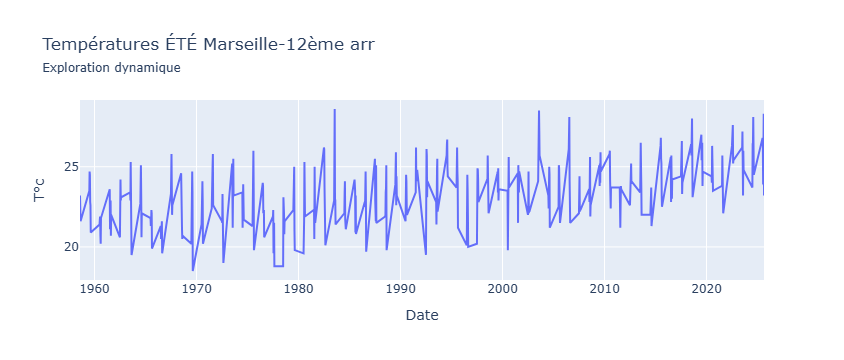

In [8]:
''' Visualiation des temperatures d'été uniquement '''
fig = px.line( x=temps_estivales_serie.index, y=temps_estivales_serie,
              title="Températures ÉTÉ Marseille-12ème arr", subtitle = "Exploration dynamique",
              labels={"x":"Date ","y":"T°c "}              
             )
fig.show()

In [9]:
''' Modélisation de la série temporelle des températures : 📉 Tendance linéaire  '''

from scipy.stats import linregress
timestamp = temps_estivales_serie.index.astype(int) / 10**9
slope, intercept, r_value, p_value, std_err = linregress(timestamp, temps_estivales_serie)
print(f"Tendance linéaire : pente = {slope:.4f}, R² = {r_value**2:.4f}")

Tendance linéaire : pente = 0.0000, R² = 0.2351


In [10]:
''' Tendance linéaire à pente nulle sur la période 1958-2024
Essai sur la période 1990-2024
'''
temps_estivales_serie_30ans = temps_estivales_serie.loc[temps_estivales_serie.index.year > 1990]
timestamp = temps_estivales_serie_30ans.index.astype(int) / 10**9
slope, intercept, r_value, p_value, std_err = linregress(timestamp, temps_estivales_serie_30ans)
print(f"Tendance linéaire : pente = {slope:.4f}, R² = {r_value**2:.4f}")

Tendance linéaire : pente = 0.0000, R² = 0.0822


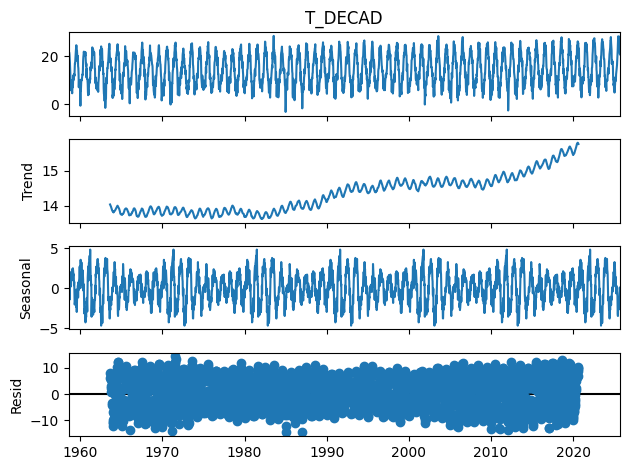

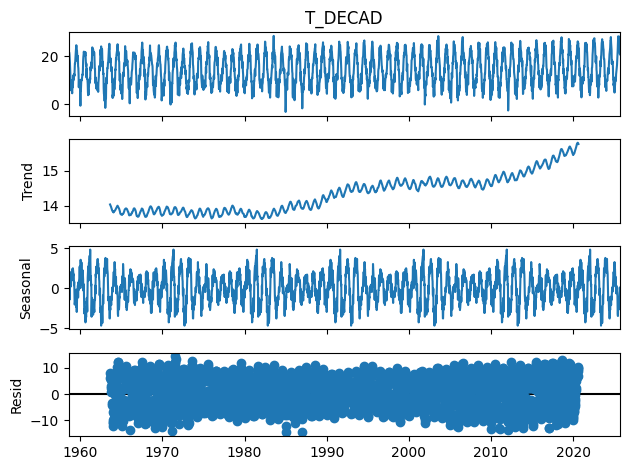

In [11]:
''' Décomposition de la série de mesures en trois composantes :
- Tendance
- Saisonalité
- Résidu
'''
from statsmodels.tsa.seasonal import seasonal_decompose

# il y a 3 valeurs par mois donc 36 valeurs par an. 
# Donc on retombe sur la même date au bout de 36 valeurs
decomposition = seasonal_decompose(temps_serie, model='additive', period = 365)
decomposition.plot()

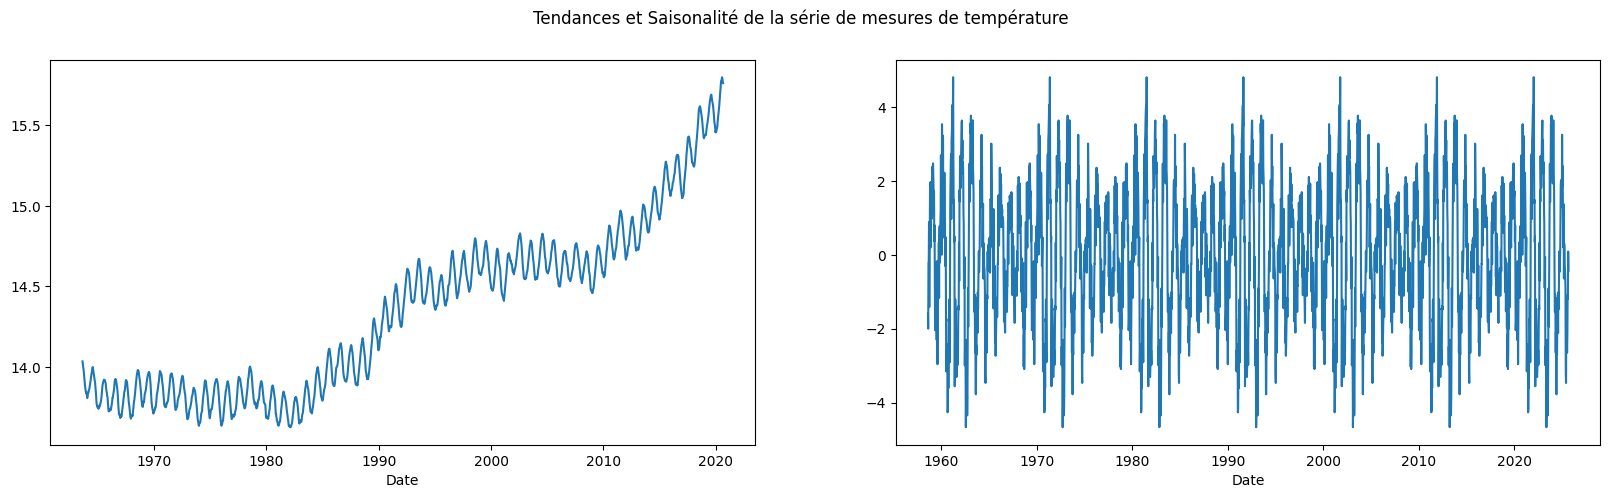

In [12]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(20,5))
axs[0].plot(decomposition.trend.index, decomposition.trend)
axs[1].plot(decomposition.seasonal.index, decomposition.seasonal)
fig.suptitle('Tendances et Saisonalité de la série de mesures de température')
for i in range(2):
    axs[i].set_xlabel('Date')

In [13]:
''' La serie de températures est-elle modelisable par ARMA: La série est-elle stationnaire ? '''
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(temps_serie)
print('La p-value du test vaut :', pvalue)

La p-value du test vaut : 7.889396372616456e-20


The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root. <br>
Ici la proba que notre série ne satisfasse pas cette hypothèse est très faible.<br>
**On considère donc que la serie est stationaire**

In [56]:
''' Modelisation ARIMA de la serie '''
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.arima.model import ARIMA

arima_result = ARIMA(temps_serie, order=(3,0,3)).fit()

arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                T_DECAD   No. Observations:                 2417
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -5161.634
Date:                Thu, 23 Oct 2025   AIC                          10339.269
Time:                        15:15:45   BIC                          10385.591
Sample:                             0   HQIC                         10356.115
                               - 2417                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.3486      0.063    228.144      0.000      14.225      14.472
ar.L1          2.1209      0.083     25.427      0.000       1.957       2.284
ar.L2         -1.3059      0.163     -8.006      0.000      -1.626      -0.986
ar.L3          0.1594      0.082      1.938      0.053      -0.002       0.321
ma.L1         -1.6816      0.086    -19.658      0.000      -1.849      -1.514
ma.L2          0.6023      0.145      4.151      0.000       0.318       0.887
ma.L3          0.1181      0.064      1.858      0.063      -0.006       0.243
sigma2         4.0220      0.109     36.958      0.000       3.809       4.235
===================================================================================
Ljung-Box (L1) (Q):                   5.36   Jarque-Bera (JB):                54.31
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                            -0.30
Prob(H) (two-sided):                  0.13   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [60]:
''' Estimation de la qualité du modèle - à uitliser pour comparer avec d'autres paramétrages ou d'autres modèles'''
print('Moyenne des erreurs au carré: ' , arima_result.mse)
print('Somme des erreurs au carré: ' , arima_result.sse)

moyenne des erreurs au carré:  4.207852699157778
Somme des erreurs au carré:  10170.379973864348


In [47]:
valeurs_modele = arima_result.predict()

In [48]:
d = {'Valeurs': temps_serie}
temps_serie_df = pandas.DataFrame(data=d, index=temps_serie.index)
temps_serie_df['Origine'] = 'Mesures'
temps_serie_df.reset_index(inplace=True)

d2 = {'Valeurs': valeurs_modele}
pred_df = pandas.DataFrame(data=d2, index=valeurs_modele.index)
pred_df['Origine'] = 'Modelisation'
pred_df.reset_index(inplace=True)

pred_df

,Date,Valeurs,Origine
0,1958-08-01,14.348580,Modelisation
1,1958-08-11,21.172236,Modelisation
2,1958-08-21,21.197065,Modelisation
3,1958-09-01,20.651169,Modelisation
4,1958-09-11,20.563170,Modelisation
...,...,...,...
2412,2025-08-01,23.076370,Modelisation
2413,2025-08-11,23.237293,Modelisation
2414,2025-08-21,23.934907,Modelisation
2415,2025-09-01,21.195460,Modelisation


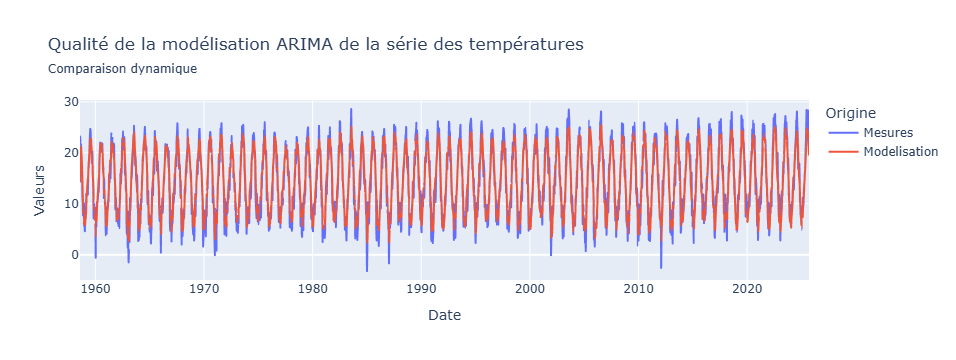

In [49]:
df_comparaison = pandas.concat([temps_serie_df, pred_df], ignore_index=True)

fig = px.line(df_comparaison, x="Date", y="Valeurs",
              title="Qualité de la modélisation ARIMA de la série des températures", subtitle = "Comparaison dynamique",
             # labels={"T_DECAD":"T°c"}, 
             # hover_data=["Date", "T_DECAD"],
              color = 'Origine'
             )
fig.show()

In [120]:
''' Prévisions pour le futur '''

'''
from datetime import datetime
predictions = arima_result.predict(start=datetime.fromisoformat('2025-08-01') ,
                           end=datetime.fromisoformat('2025-09-01') ,
                           #dynamic=date(2025,10,1), 
                           information_set='filtered')  
-> Ne permet pas de dates en dehors de celles utilisées pour l'apprentissage
'''
predictions = arima_result.forecast(steps=365)  

In [121]:
from datetime import timedelta
dates_index = pandas.DatetimeIndex(data = [(valeurs_modele.index.max() + i * timedelta(days=10)) for i in range(1,366)])
predictions_df = pandas.DataFrame(data = {'temperatures' : predictions.values}, index= dates_index)
predictions_df

,temperatures
2025-09-21,18.587644
2025-10-01,16.602604
2025-10-11,14.785335
2025-10-21,13.006941
2025-10-31,11.291942
...,...
2035-07-31,14.563680
2035-08-10,14.238759
2035-08-20,13.920260
2035-08-30,13.617845


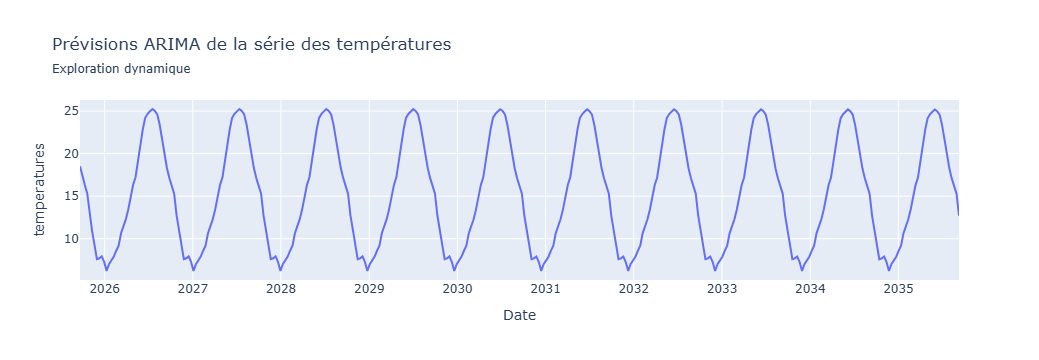

In [142]:
fig = px.line(predictions_df, x=predictions_df.index, y="temperatures",
              title="Prévisions ARIMA de la série des températures", subtitle = "Exploration dynamique",
              labels={"index":"Date"}, 
             # hover_data=["Date", "T_DECAD"],              
             )
fig.show()

In [124]:
''' Modélisation SARIMA de la serie contenant un terme saisonnier en plus dans sa modélisation '''

import statsmodels.tsa.api as tsa

model = tsa.SARIMAX(temps_serie, order=(1,0,1), seasonal_order=(1,0,1,36))
results_sarima = model.fit()

print(results_sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            T_DECAD   No. Observations:                 2417
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 36)   Log Likelihood               -5115.016
Date:                            Thu, 23 Oct 2025   AIC                          10240.033
Time:                                    16:28:57   BIC                          10268.984
Sample:                                         0   HQIC                         10250.561
                                           - 2417                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4854      0.026     18.917      0.000       0.435       0.536
ma.L1         -0.1425      0.026   

In [126]:
valeurs_sarima = results_sarima.predict()

In [147]:
d = {'Valeurs': temps_serie}
temps_serie_df = pandas.DataFrame(data=d, index=temps_serie.index)
temps_serie_df['Origine'] = 'Mesures'
temps_serie_df.reset_index(inplace=True)

d3 = {'Valeurs': valeurs_sarima}
pred_sarima_df = pandas.DataFrame(data=d3, index=valeurs_sarima.index)
pred_sarima_df['Origine'] = 'Modelisation'
pred_sarima_df.reset_index(inplace=True)

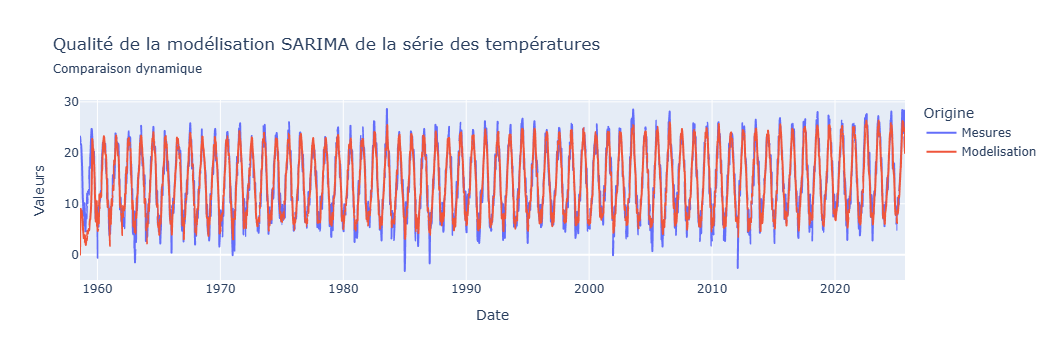

In [148]:
df_comparaison = pandas.concat([temps_serie_df, pred_sarima_df], ignore_index=True)

fig = px.line(df_comparaison, x="Date", y="Valeurs",
              title="Qualité de la modélisation SARIMA de la série des températures", subtitle = "Comparaison dynamique",
             # labels={"T_DECAD":"T°c"}, 
             # hover_data=["Date", "T_DECAD"],
              color = 'Origine'
             )
fig.show()

Cette modelisation avec SARIMA semble être plus proche des mesures réelles

In [135]:
''' Prévisions pour le futur '''
predictions = results_sarima.forecast(steps=365)  

In [136]:
lastIndex = temps_serie.index.size -1
predictions_sarima = results_sarima.predict(start=lastIndex+1, end=lastIndex+365)

In [146]:
from datetime import timedelta
dates_index = pandas.DatetimeIndex(data = [(valeurs_sarima.index.max() + i * timedelta(days=10)) for i in range(1,366)])
predictions_sarima_df = pandas.DataFrame(data = {'temperatures' : predictions_sarima.values}, index= dates_index)

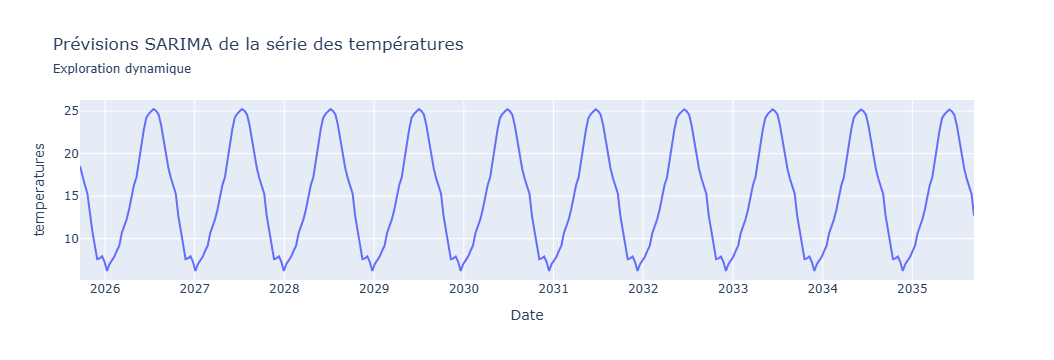

In [143]:
fig = px.line(predictions_sarima_df, x=predictions_sarima_df.index, y="temperatures",
              title="Prévisions SARIMA de la série des températures", subtitle = "Exploration dynamique",
              labels={"index":"Date"}, 
             # hover_data=["Date", "T_DECAD"],              
             )
fig.show()

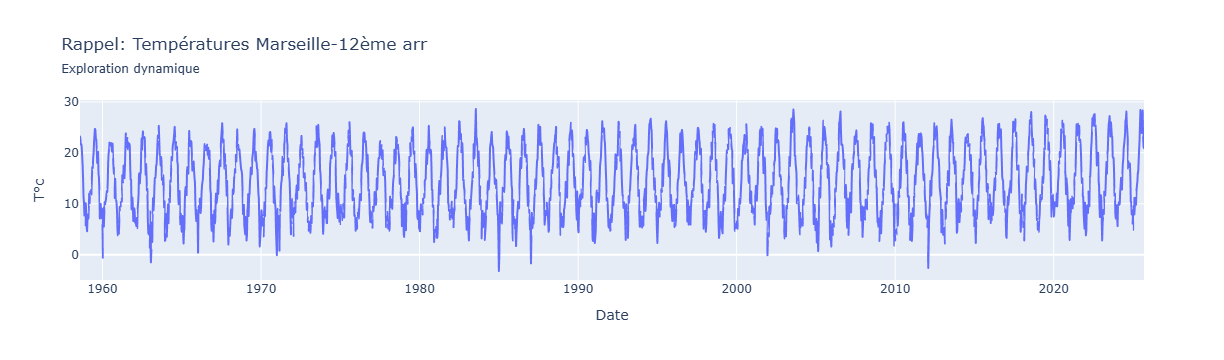

In [149]:
fig = px.line( x=temps_serie.index, y=temps_serie,
              title="Rappel: Températures Marseille-12ème arr", subtitle = "Exploration dynamique",
              labels={"x":"Date ","y":"T°c "}              
             )
fig.show()